<a href="https://colab.research.google.com/github/aditya161205/work/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
import math

In [216]:
import math

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # Added: allows 2 + Value(3)
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only int/float"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other - 1)) * out.grad

    out._backward = _backward # FIX: Unindented this line
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [217]:
a=Value(2.0,label='a')
b=Value(3.0,label='b')

c= a*b; c.label='c'
e= Value(5,label='e')
d= c+ e
d.label='d'

f=Value(-2,label='f')

L = d*f
L.label='L'


In [218]:
1+a

Value(data=3.0)

In [219]:
c._op

'*'

In [220]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [221]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias
b= Value(10,label='b')
#x1w1 + x2w2 + b

x1w1=x1*w1
x1w1.label='x1*w1'
x2w2=x2*w2
x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n=x1w1x2w2 + b; n.label='n'
o=n.tanh();o.label='o'



In [222]:
# # 1. Start with o.grad (dL/do)
# o.grad = 1.0

# # 2. Backprop through tanh
# # do/dn = 1 - tanh(n)^2 = 1 - o^2
# n.grad = (1 - o.data**2) * o.grad

# # 3. Backprop through addition (n = x1w1x2w2 + b)
# # Gradients distribute equally across addition
# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# # 4. Backprop through addition (x1w1x2w2 = x1w1 + x2w2)
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # 5. Backprop through multiplication (x1w1 = x1 * w1)
# # Swap values: x1 gets w1's data, w1 gets x1's data
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# # 6. Backprop through multiplication (x2w2 = x2 * w2)
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

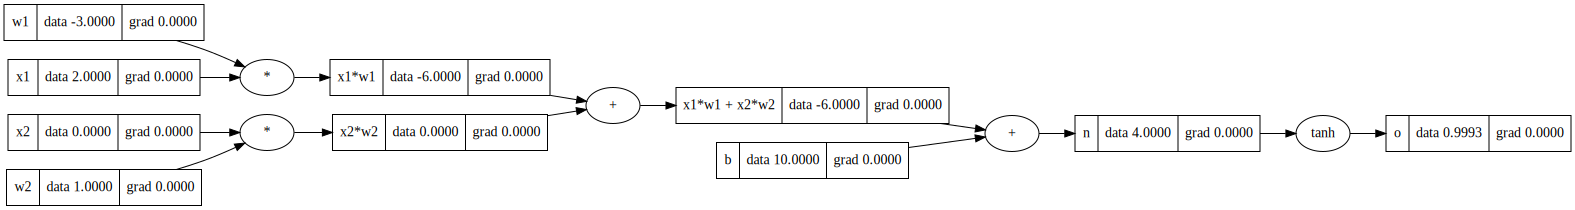

In [223]:
draw_dot(o)

In [224]:
o.backward()

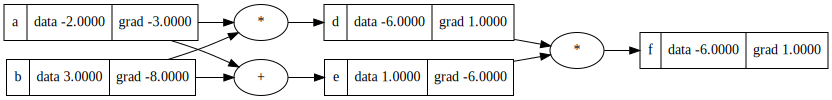

In [225]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [226]:
import torch

In [227]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [228]:
import random

In [229]:
class Neuron:

  def __init__(self,nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    #w*x + b
    act =sum(wi*xi for  wi,xi in zip(self.w,x)) + self.b
    out = act.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self,nin,nout):
    self.neurons= [Neuron(nin) for _ in range(nout)]
  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps= neuron.parameters()
      params.extend(ps)
    return params

class MLP:

  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [230]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)


Value(data=0.542256927950498)

In [231]:
len(n.parameters())

41

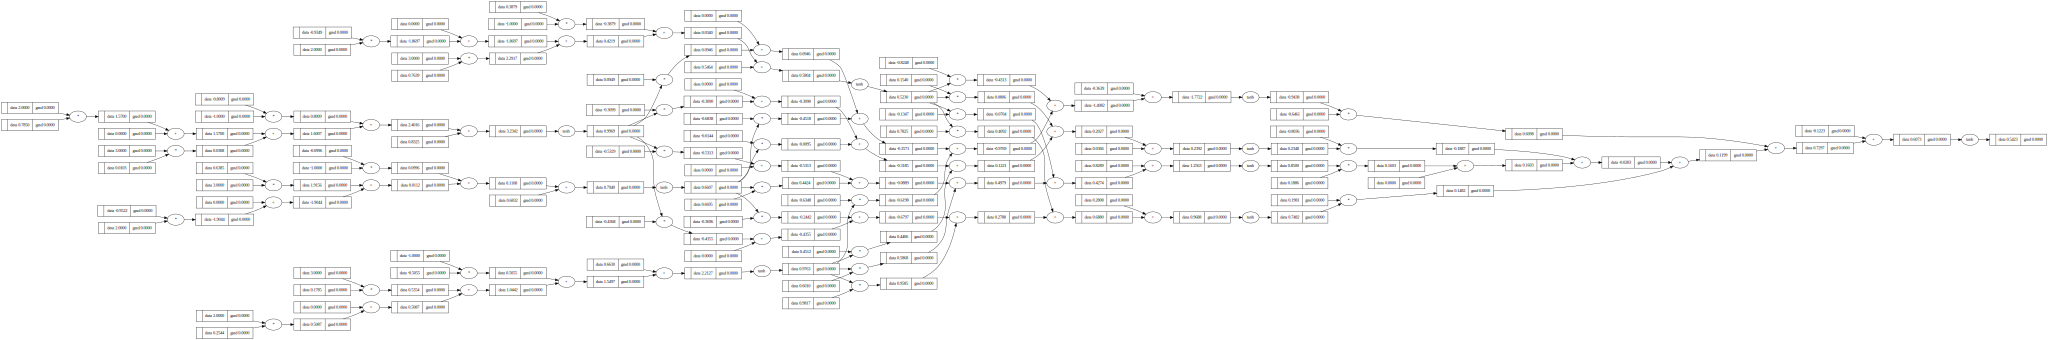

In [232]:
draw_dot(n(x))

In [233]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [235]:
for k in range(10):
  #forward pass
  ypred= [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
  #backward pass
  for p in n.parameters(): #zero grad
    p.grad = 0.0
  loss.backward()
  #update
  for p in n.parameters():
    p.data+= -0.05 * p.grad
  print(k,loss.data)



0 0.040996117384932515
1 0.030178822090981435
2 0.02560741416604826
3 0.0225962673153444
4 0.0203420085709053
5 0.01854576938472689
6 0.01706142149289209
7 0.015805351598380382
8 0.014724486932361436
9 0.013782598269224974
